<a href="https://colab.research.google.com/github/DanDaeK/Citadel-Datathon/blob/main/Copy_of_Grid_Sorting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
ordered_ids = [107,
 122,
 189,
 169,
 190,
 123,
 167,
 142,
 106,
 124,
 143,
 232,
 147,
 86,
 166,
 67,
 186,
 187,
 127,
 83,
 188,
 207,
 208,
 248,
 102,
 62,
 228,
 85,
 212,
 103,
 229,
 168,
 170,
 66,
 246,
 227,
 87,
 146,
 267,
 126,
 249,
 252,
 148,
 233,
 125,
 144,
 226,
 211,
 247,
 128,
 234,
 149,
 273,
 63,
 287,
 268,
 254,
 191,
 253,
 108,
 255,
 230,
 266,
 65,
 231,
 213,
 141,
 250,
 251,
 162,
 104,
 68,
 209,
 210,
 171,
 82,
 165,
 272,
 105,
 42,
 271,
 265,
 88,
 223,
 286,
 145,
 243,
 163,
 315,
 306,
 339,
 206,
 235,
 205,
 293,
 140,
 288,
 184,
 224,
 274,
 292,
 192,
 245,
 338,
 355,
 46,
 335,
 294,
 185,
 269,
 295,
 256,
 318,
 276,
 285,
 296,
 312,
 47,
 236,
 314,
 375,
 183,
 204,
 282,
 356,
 317,
 298,
 225,
 307,
 270,
 150,
 319,
 121,
 376,
 304,
 2,
 334,
 277,
 396,
 161,
 22,
 358,
 262,
 193,
 84,
 3,
 275,
 43,
 242,
 297,
 263,
 41,
 21,
 357,
 291,
 45,
 336,
 101,
 305,
 48,
 359,
 129,
 64,
 284,
 377,
 354,
 182,
 244,
 1,
 214,
 278,
 264,
 313,
 333,
 164,
 26,
 257,
 303,
 172,
 311,
 395,
 222,
 316,
 397,
 302,
 23,
 337,
 378,
 374,
 353,
 283,
 281,
 160,
 25,
 323,
 151,
 379,
 332,
 261,
 241,
 258,
 173,
 203,
 61,
 24,
 44,
 4,
 289,
 27,
 324,
 6]

In [ ]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
stations = pd.read_csv('/content/drive/Shared With Me/2023 Datathon/data/citadel datasets/tio/police_stations.csv')

FileNotFoundError: ignored

In [ ]:
crimes = pd.read_csv ('/content/drive/My Drive/2023 Datathon/data/citadel datasets/tio/crimes.csv')

In [ ]:
crimes['year'] = pd.DatetimeIndex(crimes['dispatch_date']).year

In [ ]:
min_lat = crimes['lat'].min()
max_lat = crimes['lat'].max()
min_lon = crimes['lng'].min()
max_lon = crimes['lng'].max()

# split city into 400 grids
num_grids_side = 20
lat_step = (max_lat - min_lat) / num_grids_side
lon_step = (max_lon - min_lon) / num_grids_side

# assign a grid number to each crime
crimes['grid'] = 0
for i in range(num_grids_side):
    for j in range(num_grids_side):
        crimes.loc[(crimes['lat'] >= min_lat + i * lat_step) & (crimes['lat'] < min_lat + (i + 1) * lat_step) & (crimes['lng'] >= min_lon + j * lon_step) & (crimes['lng'] < min_lon + (j + 1) * lon_step), 'grid'] = i * num_grids_side + j

# count number of crimes in each grid
grid_counts = crimes.groupby('grid').size().reset_index(name='counts')

# calculate size of each grid in feet
lat_size = 364000 * lat_step
lon_size = 364000 * lon_step

In [ ]:
grids = pd.DataFrame()

grids['id'] = [str(i) for i in range(400)]
for i in range(2014, 2023):
  grids[str(i)] = ''

for i in range(2014, 2023):
  year = crimes.loc[crimes['year'] == i]
  print(year.head())
  for j in range(400):
    grid_year = year.loc[year['grid'] == j]
    grids[str(i)][j] = len(grid_year)

In [ ]:
yearly_crime = grids.sum(axis=0)
yearly_crime = yearly_crime.drop(labels = 'id')
print(yearly_crime.head())

In [ ]:
ycarr = yearly_crime.to_numpy()[:6]
garr = grids.to_numpy()[:, 1:7]

grids['slope'] = ''
grids['intercept'] = ''

for i in range(garr.shape[0]):
  y = garr[i]
  model = LinearRegression()
  x = ycarr - y
  model.fit(x.reshape((-1, 1)), y)
  grids['slope'][i] = model.coef_
  grids['intercept'][i] = model.intercept_

In [ ]:
import matplotlib.pyplot as plt

def abline(slope, intercept, label = ''):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label = label)

def plot_grid(i):
  arr = grids.iloc[i].to_numpy()
  y = arr[1:7]
  x = ycarr - y
  plt.scatter(x, y, label = 'pre-OP data')

  yp = arr[7:10]
  xp = yearly_crime.to_numpy()[6:9] - yp
  plt.scatter(xp, yp, c='orange', label = 'post-OP data')

  abline(grids['slope'][i], grids['intercept'][i], label = 'line fit to pre-OP data')
  plt.xlabel('Number of crimes committed in Philadelphia')
  plt.ylabel('Number of crimes committed in grid box ' + str(i))
  plt.legend()
  plt.show()

In [ ]:
plot_grid(0)

In [ ]:
import matplotlib.pyplot as plt


def create_heatmap(num_grids_side, grid_counts):
    # Create the crime percentage grid
    crime_pct_grid = np.zeros((num_grids_side, num_grids_side))
    for index, row in grid_counts.iterrows():
        grid_num = row['grid']
        row_num = int(grid_num // num_grids_side)
        col_num = int(grid_num % num_grids_side)
        crime_pct_grid[row_num, col_num] = row['crime_pct']
    
    # Create the heatmap using `imshow` function
    heatmap = plt.imshow(crime_pct_grid, cmap='Blues', vmin=0, vmax=3.6)
    
    # Add a colorbar
    cbar = plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Percentage of total crimes', rotation=270, labelpad=15)
    
    # Set the tick labels for x and y axis
    xtick_labels = [f'{min_lon + (i + 0.5) * lon_step:.2f}' for i in range(num_grids_side)]
    ytick_labels = [f'{min_lat + (i + 0.5) * lat_step:.2f}' for i in range(num_grids_side)]
    plt.xticks(range(num_grids_side), xtick_labels, rotation=90)
    plt.yticks(range(num_grids_side), ytick_labels)
    
    # Set the x and y axis labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Crime density heatmap')
    
    # Display the plot
    plt.show()

create_heatmap(num_grids_side, grid_counts)



NameError: ignored

In [ ]:
import matplotlib.pyplot as plt


def create_heatmap(num_grids_side, grid_counts):
    # Create the crime percentage grid
    crime_pct_grid = np.zeros((num_grids_side, num_grids_side))
    for index, row in grid_counts.iterrows():
        grid_num = row['grid']
        row_num = int(grid_num // num_grids_side)
        col_num = int(grid_num % num_grids_side)
        crime_pct_grid[row_num, col_num] = row['crime_pct']
    
    # Create the heatmap using `imshow` function
    heatmap = plt.imshow(crime_pct_grid, cmap='Blues', vmin=0, vmax=3.6)
    
    # Add a colorbar
    cbar = plt.colorbar(heatmap, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('Percentage of total crimes', rotation=270, labelpad=15)
    
    # Set the tick labels for x and y axis
    xtick_labels = [f'{min_lon + (i + 0.5) * lon_step:.2f}' for i in range(num_grids_side)]
    ytick_labels = [f'{min_lat + (i + 0.5) * lat_step:.2f}' for i in range(num_grids_side)]
    plt.xticks(range(num_grids_side), xtick_labels, rotation=90)
    plt.yticks(range(num_grids_side), ytick_labels)
    
    # Set the x and y axis labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Crime density heatmap')
    
    # Display the plot
    plt.show()

create_heatmap(num_grids_side, grid_counts)


NameError: ignored

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import plotly.graph_objects as go



def overlay_heatmap(num_grids_side, grid_counts, lon, lat):
    # Create the figure
    fig = plt.figure(figsize=(10, 8))

    # Add the map projection
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    # Set the extent of the map
    ax.set_extent([min_lon, max_lon, min_lat, max_lat])

    # Add the land and ocean features to the map
    ax.add_feature(ccrs.feature.LAND)
    ax.add_feature(ccrs.feature.OCEAN)

    # Add the scatter plot of the given longitude and latitude
    ax.scatter(lon, lat, color='red', transform=ccrs.Geodetic())

    # Call the create_heatmap function to create the heatmap
    create_heatmap(num_grids_side, grid_counts)

    # Display the plot
    plt.show()


# Define the longitude and latitude
lon = -75.1637
lat = 39.9526

# Define the min and max longitude and latitude
min_lon, max_lon = -75.3, -75.0
min_lat, max_lat = 39.8, 40.2

# Define the number of grids on each side of the heatmap
num_grids_side = 20

# Define the grid counts
grid_counts = pd.DataFrame({'grid': range(num_grids_side**2), 'crime_pct': np.random.uniform(low=0, high=3.6, size=num_grids_side**2)})

# Overlay the heatmap over the given longitude and latitude
overlay_heatmap(num_grids_side, grid_counts, lon, lat)


ModuleNotFoundError: ignored

In [ ]:
!pip install cartopy
import cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 31.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 5.2 MB/s eta 0:00:00
  Created wheel for cartopy: filename=Cartopy-0.21.1-cp39-cp39-linux_x86_64.whl size=11113685 sha256=45ecdf05fe08e6c172e63661f7fce33001070d423a0b6f692efb8b9a8bec273b
  Stored in directory: /root/.cache/pip/wheels/74/b9/f5/2c94acd7cd21480e6cf63169144d7aac3e8d9cf638225ed578
Successfully built cartopy


In [ ]:
def line(slope, intercept, point):
  return slope * point + intercept

In [ ]:
grids['avg_pred_error'] = ''

for i in range(400):
  error = 0
  for year in range(2020, 2023):
    x0 = yearly_crime.to_numpy()[year - 2014]
    pred = line(grids['slope'][i], grids['intercept'][i], x0)
    true = grids[str(year)][i]
    error += (- pred + true)
  grids['avg_pred_error'][i] = error / 3

In [ ]:
n = len(ordered_ids)

def compare_errors(current):
  pinpoint_errors = []
  for i in current:
    error = grids['avg_pred_error'][i]
    pinpoint_errors.append(error)

  pinpoint_errors = np.array(pinpoint_errors)
  return np.mean(pinpoint_errors)

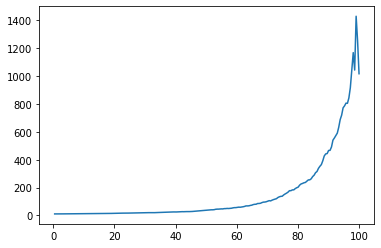

In [ ]:
# cumulative effect plot

effects = []
cur = []
for i in range(n):
  cur.append(ordered_ids[i])
  effects.append(compare_errors(cur))
plt.plot(100 - 100 * np.array(range(n)) / n, -1 * np.array(effects))
plt.show()

In [ ]:
x = 100 - 100 * np.array(range(n)) / n
y = -1 * np.array(effects)

In [ ]:
print(grids.head())

  id  2014  2015  2016  2017  2018  2019  2020  2021  2022  \
0  0  2181  2054  1688  1691  1918  1760  1381  1957  2539   
1  1    72    72    51    69    57    57    77   126   134   
2  2   232   161   200   159   142   113   149   126   143   
3  3   135   151   112    99   153   205   116   109   141   
4  4     1     2     2     2     1     1     1     0     0   

                     slope   intercept         avg_pred_error  
0    [0.01638673486182194] -794.879653    [445.2782104070632]  
1  [0.0006525709146426297]  -44.788727    [65.18634732456583]  
2   [0.002401542959637794] -228.590964   [29.589321622038796]  
3  [7.358038942295116e-05]  130.352172   [-18.71834897730913]  
4  [2.699588615466943e-06]    1.053928  [-1.1009190857998412]  


In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Scattermapbox(
    fill = "toself",
    lon = [-75.27898186, -74.95753244, -74.95753244, -75.27898186], lat = [39.87502075, 39.87502075, 40.13771285, 40.13771285],
    marker = { 'size': 10, 'color': "orange" }))

fig.update_layout(
    mapbox = {
        'style': "stamen-terrain",
        'center': {'lon': -75, 'lat': 40 },
        'zoom': 9},
    showlegend = False)

fig.show()

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Scattermapbox(lon = [-75.27898186, -74.95753244, -74.95753244, -75.27898186], lat = [39.87502075, 39.87502075, 40.13771285, 40.13771285], marker = {'size': 10, 'color': 'orange'}))

fig.update_layout(
    mapbox = {
        'style': "stamen-terrain",
        'center': {'lon': -75, 'lat': 40 },
        'zoom': 9},
    showlegend = False, title = 'Map of the region that our data covers')

fig.show()